<a href="https://colab.research.google.com/github/Matrixmax/Dive_into_DeepLearning/blob/main/0x32_%E7%A8%A0%E5%AF%86%E9%93%BE%E6%8E%A5%E7%BD%91%E7%BB%9C%EF%BC%88DenseNet%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ResNet中的跨层连接设计引申出了数个后续工作。本节我们介绍其中的一个：稠密连接网络（DenseNet） [1]。 它与ResNet的主要区别如图5.10所示。

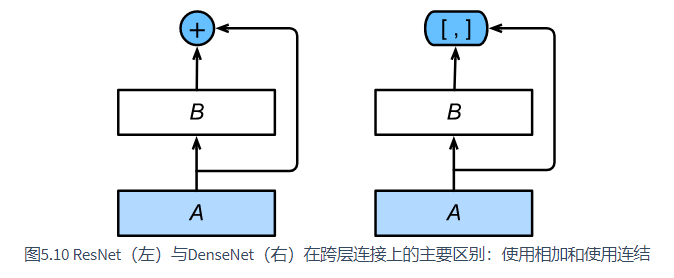

图5.10中将部分前后相邻的运算抽象为模块AA和模块BB。与ResNet的主要区别在于，DenseNet里模块BB的输出不是像ResNet那样和模块AA的输出相加，而是在通道维上连结。这样模块AA的输出可以直接传入模块BB后面的层。在这个设计里，模块AA直接跟模块BB后面的所有层连接在了一起。这也是它被称为“稠密连接”的原因。

DenseNet的主要构建模块是稠密块（dense block）和过渡层（transition layer）。前者定义了输入和输出是如何连结的，后者则用来控制通道数，使之不过大。

## 1. 稠密块
DenseNet使用了ResNet改良版的“批量归一化、激活和卷积”结构，我们首先在conv_block函数里实现这个结构。

In [24]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F
import sys
from google.colab import drive
import d2lzh_pytorch as d2l
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks/Dive_Into_Deep_Learning')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Wed Feb 17 14:37:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

稠密块由多个conv_block组成，每块使用相同的输出通道数。但在前向计算时，我们将每块的输入和输出在通道维上连结。

In [32]:
def conv_block(in_channels, out_channels):
    blk = nn.Sequential(
        nn.BatchNorm2d(in_channels), 
        nn.ReLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    return blk

In [33]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, in_channels, out_channels):
        super(DenseBlock, self).__init__()
        net = []
        for i in range(num_convs):
            in_c = in_channels + i * out_channels
            net.append(conv_block(in_c, out_channels))
        self.net = nn.ModuleList(net)
        self.out_channels = in_channels + num_convs * out_channels # 计算输出通道数

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)  # 在通道维上将输入和输出连结
        return X


在下面的例子中，我们定义一个有2个输出通道数为10的卷积块。使用通道数为3的输入时，我们会得到通道数为3+2×10=23的输出。卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为增长率（growth rate）。

In [34]:
blk = DenseBlock(2, 3, 10)
X = torch.rand(4, 3, 8, 8)
Y = blk(X)
Y.shape # torch.Size([4, 23, 8, 8])

torch.Size([4, 23, 8, 8])

## 2.过渡层
由于每个稠密块都会带来通道数的增加，使用过多则会带来过于复杂的模型。过渡层用来控制模型复杂度。它通过1×1卷积层来减小通道数，并使用步幅为2的平均池化层减半高和宽，从而进一步降低模型复杂度。

In [35]:
def transition_block(in_channels, out_channels):
    blk = nn.Sequential(
            nn.BatchNorm2d(in_channels), 
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.AvgPool2d(kernel_size=2, stride=2))
    return blk

In [36]:
blk = transition_block(23, 10)
blk(Y).shape # torch.Size([4, 10, 4, 4])


torch.Size([4, 10, 4, 4])

## 3.DenseNet模型
我们来构造DenseNet模型。DenseNet首先使用同ResNet一样的单卷积层和最大池化层。

In [37]:
net = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


类似于ResNet接下来使用的4个残差块，DenseNet使用的是4个稠密块。同ResNet一样，我们可以设置每个稠密块使用多少个卷积层。这里我们设成4，从而与上一节的ResNet-18保持一致。稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。

ResNet里通过步幅为2的残差块在每个模块之间减小高和宽。这里我们则使用过渡层来减半高和宽，并减半通道数。

In [38]:
num_channels, growth_rate = 64, 32  # num_channels为当前的通道数
num_convs_in_dense_blocks = [4, 4, 4, 4]

for i, num_convs in enumerate(num_convs_in_dense_blocks):
    DB = DenseBlock(num_convs, num_channels, growth_rate)
    net.add_module("DenseBlosk_%d" % i, DB)
    # 上一个稠密块的输出通道数
    num_channels = DB.out_channels
    # 在稠密块之间加入通道数减半的过渡层
    if i != len(num_convs_in_dense_blocks) - 1:
        net.add_module("transition_block_%d" % i, transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [39]:
net.add_module("BN", nn.BatchNorm2d(num_channels))
net.add_module("relu", nn.ReLU())
net.add_module("global_avg_pool", d2l.GlobalAvgPool2d()) # GlobalAvgPool2d的输出: (Batch, num_channels, 1, 1)
net.add_module("fc", nn.Sequential(d2l.FlattenLayer(), nn.Linear(num_channels, 10))) 


In [40]:
X = torch.rand((1, 1, 96, 96))
for name, layer in net.named_children():
    X = layer(X)
    print(name, ' output shape:\t', X.shape)


0  output shape:	 torch.Size([1, 64, 48, 48])
1  output shape:	 torch.Size([1, 64, 48, 48])
2  output shape:	 torch.Size([1, 64, 48, 48])
3  output shape:	 torch.Size([1, 64, 24, 24])
DenseBlosk_0  output shape:	 torch.Size([1, 192, 24, 24])
transition_block_0  output shape:	 torch.Size([1, 96, 12, 12])
DenseBlosk_1  output shape:	 torch.Size([1, 224, 12, 12])
transition_block_1  output shape:	 torch.Size([1, 112, 6, 6])
DenseBlosk_2  output shape:	 torch.Size([1, 240, 6, 6])
transition_block_2  output shape:	 torch.Size([1, 120, 3, 3])
DenseBlosk_3  output shape:	 torch.Size([1, 248, 3, 3])
BN  output shape:	 torch.Size([1, 248, 3, 3])
relu  output shape:	 torch.Size([1, 248, 3, 3])
global_avg_pool  output shape:	 torch.Size([1, 248, 1, 1])
fc  output shape:	 torch.Size([1, 10])


## 4. 获取数据并训练模型



In [41]:
batch_size = 256
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


training on  cuda
epoch 1, loss 0.4580, train acc 0.838, test acc 0.858, time 34.3 sec
epoch 2, loss 0.2711, train acc 0.901, test acc 0.885, time 34.2 sec
epoch 3, loss 0.2324, train acc 0.915, test acc 0.877, time 34.5 sec
epoch 4, loss 0.2084, train acc 0.924, test acc 0.911, time 34.6 sec
epoch 5, loss 0.1892, train acc 0.930, test acc 0.906, time 34.7 sec
